# Digit Classification with Logistic Regression

In this notebook we will use simple logistic regression to see how far we can get when classifying images with digits on it. For this we use the famous MNIST dataset.

### 1. Data Loading and Analysis

We work with the MNIST dataset which is a large database of handwritten digits and very popular for testing machine learning models. You can find more details about the dataset [here](https://en.wikipedia.org/wiki/MNIST_database).

We download the dataset directly via the sklearn library. This may take a short while ... 

In [1]:
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

Next, we have a brief look at the data:

In [2]:
print("X is a", type(x))
print("y is a", type(y))

X is a <class 'pandas.core.frame.DataFrame'>
y is a <class 'pandas.core.series.Series'>


In [3]:
x.shape

(70000, 784)

In [4]:
x.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One data point consists of 784 pixel values (=28x28 pixels) that represent an image showing a handwritten digit.
Let's look at the data for one data point:

In [5]:
x.iloc[0].describe()

count    784.000000
mean      35.108418
std       79.699674
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      255.000000
Name: 0, dtype: float64

The pixels of one datapoint have values between 0 and 255 which correspond to the grey value of that pixel. A value of zero means that the pixel is black, a value of 255 corresponds to a white pixel, every other value is some grey value in between.

The labels of the data are the digits that are actually shown on the image:

In [6]:
y.head(3)

0    5
1    0
2    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [7]:
type(y.iloc[0])

str

Since the label is of type string, we convert it to an integer:

In [8]:
y = y.astype("int")

To get an impression how the pictures of the digits look like, we visualize the first three rows with matplotlib. For this, we need to reshape each row to dimension 28x28 and then plot it.

(-0.5, 27.5, 27.5, -0.5)

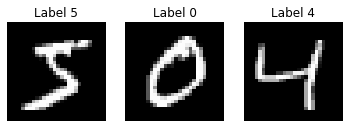

In [9]:
import numpy as np
import matplotlib.pyplot as plt

digit = x.iloc[0]
digit_pixels = np.array(digit).reshape(28, 28)
plt.subplot(131)
plt.title("Label " + str(y.iloc[0]))
plt.imshow(digit_pixels, cmap=plt.cm.gray)
plt.axis('off')

digit = x.iloc[1]
digit_pixels = np.array(digit).reshape(28, 28)
plt.subplot(132)
plt.title("Label " + str(y.iloc[1]))
plt.imshow(digit_pixels, cmap=plt.cm.gray)
plt.axis('off')

digit = x.iloc[2]
digit_pixels = np.array(digit).reshape(28, 28)
plt.subplot(133)
plt.title("Label " + str(y.iloc[2]))
plt.imshow(digit_pixels, cmap=plt.cm.gray)
plt.axis('off')

Before we start with the model training we divide it into train and test data.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print("Train data points:", len(X_train))
print("Test data points:", len(X_test))

Train data points: 56000
Test data points: 14000


### 2. Model Training

In the first step we normalize the data with min-max normaliziation:

In [11]:
X_train = (X_train/255).astype('float32').values # min-max-normalize
X_test = (X_test/255).astype('float32').values # min-max-normalize

Since this is a multiclass classficiation problem, we will use an one-vs-rest approch for logisitc regession, which means that we train an individual model for each digit.

In order to do that, we need for each model an individual representation of the label, in which only the digit on which the model is trained on is `1` on the rest is zero. For this we impelement the following function:

In [12]:
def label_to_binary(digit, labels):
    binary_labels = []
    for label in labels:
        if(label == digit):
            binary_labels.append(1)
        else:
            binary_labels.append(0)
    return np.array(binary_labels)

To test this, we train a model that only predicts if there is a "9" on the image:

In [13]:
y_train_9 = label_to_binary(9, y_train)
y_test_9 = label_to_binary(9, y_test)

print("Old labels:", y_train[:10].values)
print("New labels:", y_train_9[:10])

Old labels: [4 9 6 7 5 1 9 6 7 9]
New labels: [0 1 0 0 0 0 1 0 0 1]


In [14]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter=1000) # Gradient Descent with max. 1000 steps
logisticRegr.fit(X_train, y_train_9)

LogisticRegression(max_iter=1000)

In [15]:
from sklearn.metrics import accuracy_score
predictions = logisticRegr.predict(X_test)
accuracy_score(y_test_9, predictions)

0.966

We next train a model for every digit:

In [16]:
models = []
for i in range(0, 10):
    logisticRegr = LogisticRegression(max_iter=1000)
    y_train_binary = label_to_binary(i, y_train)
    logisticRegr.fit(X_train, y_train_binary)
    models.append(logisticRegr)

### 3. Model Testing

For testing, we now predict with every model on a test data point and use the model which has the highest probabilty as prediction result.

In [17]:
test_predictions = []
for data_point in X_test:
    predictions = []
    for model in models:  
        prediction = model.predict_proba([data_point])[0][1]
        predictions.append(prediction)
    predicted_class = predictions.index(max(predictions))
    test_predictions.append(predicted_class)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predictions)

0.9098571428571428

### 4. Cross-Validation

We do the same as above but try out different lambdas for the regulariuzation.
Note: We only train one `LogisticRegression` object in this case, because the `LogisticRegression` class does the "one-vs-rest" by default when confronted with more than two classes :)

In [19]:
from sklearn.model_selection import GridSearchCV

parameter_candidates = [{'C': [0.1, 1.0, 10.0]}]

logisticRegr = LogisticRegression(max_iter=1000)
grid_lr = GridSearchCV(estimator=logisticRegr, param_grid=parameter_candidates, n_jobs=-1)
grid_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': [0.1, 1.0, 10.0]}])

In [20]:
from sklearn.metrics import accuracy_score
predictions = grid_lr.predict(X_test)
accuracy_score(y_test, predictions)

0.9187142857142857

/opt/miniconda3/envs/dmml2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/dmml2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis